In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
from tqdm import tqdm
from scipy.signal import convolve2d
import seaborn as sns
from deliverable_1 import *

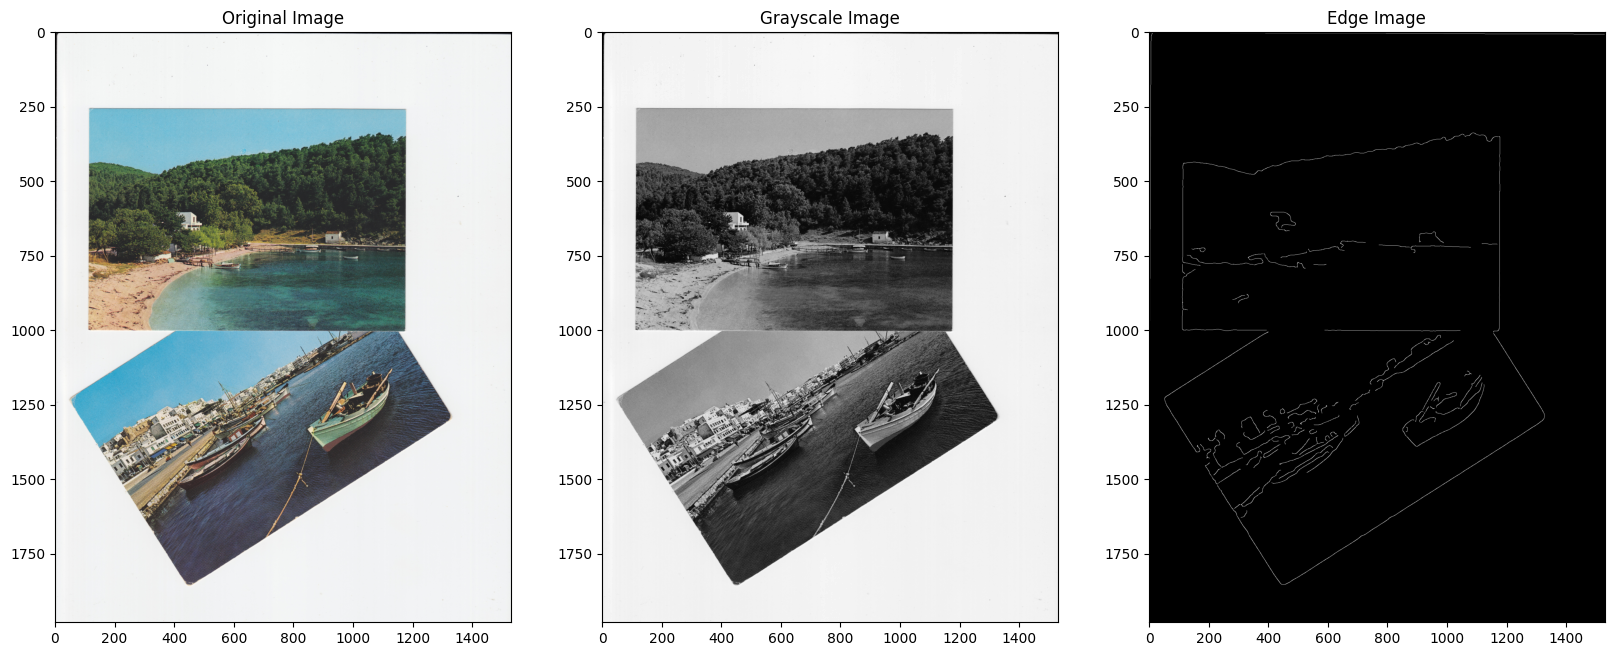

In [2]:
# remove the outer 50px frame of the image
original = io.imread("data/im2.jpg")
# crop the original
original = original
# resize original image to a tenth of its size
original = cv.resize(original, (0, 0), fx=0.3, fy=0.3)
gray = color.rgb2gray(original)
binary = feature.canny(gray, sigma=5)


def plot_images(images, titles, figsize=(20, 20)):
    fig, axs = plt.subplots(1, len(images))
    fig.set_size_inches(figsize)
    for ax, image, title in zip(axs, images, titles):
        ax.set_title(title)
        ax.imshow(image, cmap="gray")


plot_images(
    [original, gray, binary],
    ["Original Image", "Grayscale Image", "Edge Image"],
)

In [3]:
# Example usage
# img_binary = ... (your binary image here)
d_rho = 5
d_theta = np.pi / 180
n = 10
H, L, res = my_hough_transform(binary, d_rho, d_theta, n)

Performing Hough Transform:   0%|          | 0/19046 [00:00<?, ?pixels/s]

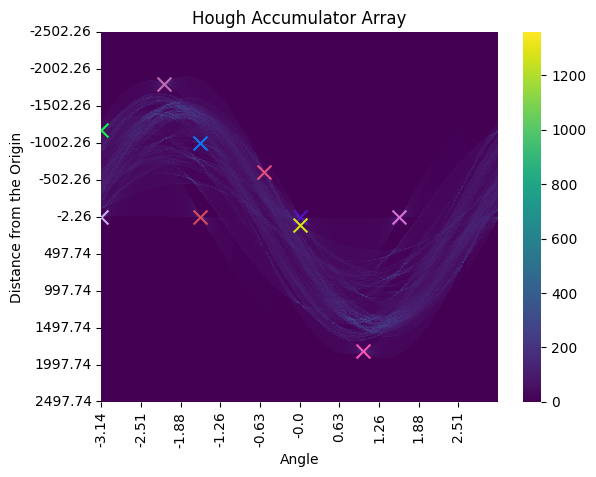

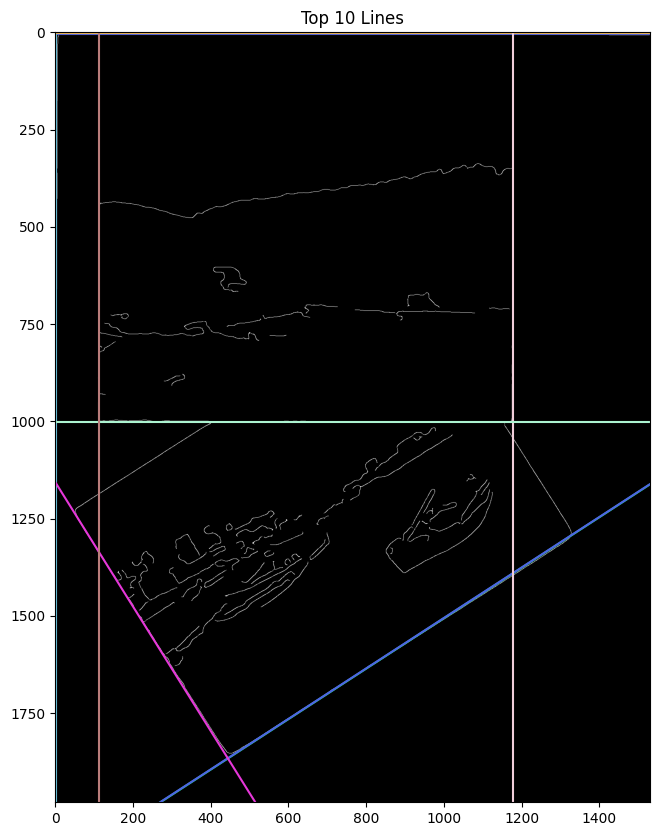

In [4]:
# Get the dimensions of the input binary image
height, width = binary.shape

# Calculate the maximum possible value of rho
max_rho = np.sqrt(height**2 + width**2)
rhos = np.arange(-max_rho, max_rho, d_rho)
thetas = np.arange(-np.pi, np.pi, d_theta)
# Plot the Hough accumulator array
ax = sns.heatmap(H, cmap="viridis")
ax.set_title("Hough Accumulator Array")
ax.set_xlabel("Angle")
ax.set_ylabel("Distance from the Origin")

ax.set_xticks(np.arange(0, len(thetas), len(thetas) // 10))
ax.set_xticklabels(np.round(thetas[:: len(thetas) // 10], 2))

ax.set_yticks(np.arange(0, len(rhos), len(rhos) // 10))
ax.set_yticklabels(np.round(rhos[:: len(rhos) // 10], 2))

# Scatter rho, theta pairs
for rho, theta in L:
    # add different color for each line to make it easier to distinguish NOT RANDOM
    color = np.random.rand(
        3,
    )
    ax.scatter(
        thetas.tolist().index(theta),
        rhos.tolist().index(rho),
        c=[color],
        s=100,
        marker="x",
    )

plt.figure(figsize=(10, 10))
for rho, theta in L:
    color = np.random.rand(
        3,
    )
    p0 = np.array([rho * np.cos(theta), rho * np.sin(theta)])
    direction = np.array([p0[1], -p0[0]]) / np.linalg.norm(p0)
    p1 = p0 + 5000 * direction
    p2 = p0 - 5000 * direction
    # plt.plot(p0[0], p0[1], "ro")
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c=color)
plt.imshow(original, cmap="gray")
plt.title(f"Top {len(L)} Lines")
plt.show()

In [5]:
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma**2))
        * np.exp(
            -((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma**2)
        ),
        (size, size),
    )
    return kernel / np.sum(kernel)


def harris_response(img: np.ndarray, k: float, sigma: float) -> np.ndarray:
    # Sobel kernels
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Compute the image gradients
    I_x = convolve2d(img, sobel_x, mode="same")
    I_y = convolve2d(img, sobel_y, mode="same")

    # Gaussian kernel
    size = int(4 * sigma)  # typically 3-sigma rule
    gaussian_kernel_ = gaussian_kernel(size, sigma)

    # Compute the elements of the structure tensor
    I_x2 = convolve2d(I_x**2, gaussian_kernel_, mode="same")
    I_y2 = convolve2d(I_y**2, gaussian_kernel_, mode="same")
    I_xy = convolve2d(I_x * I_y, gaussian_kernel_, mode="same")

    # Compute the Harris response
    det = I_x2 * I_y2 - I_xy**2
    trace = I_x2 + I_y2
    response = det - k * trace**2

    return response


def corner_locations(harris_response: np.ndarray, rel_threshold: float) -> np.ndarray:
    # Compute the threshold
    threshold = rel_threshold * harris_response.max()
    # Find corners by applying a threshold
    corner_locations = harris_response > threshold
    # Find the indices of the corners
    corner_locations = np.argwhere(corner_locations)
    return corner_locations

In [8]:
k = 0.04
sigma = 3.0
response = harris_response(gray, k, sigma)
rel_threshold = 0.1
corners = corner_locations(response, rel_threshold)

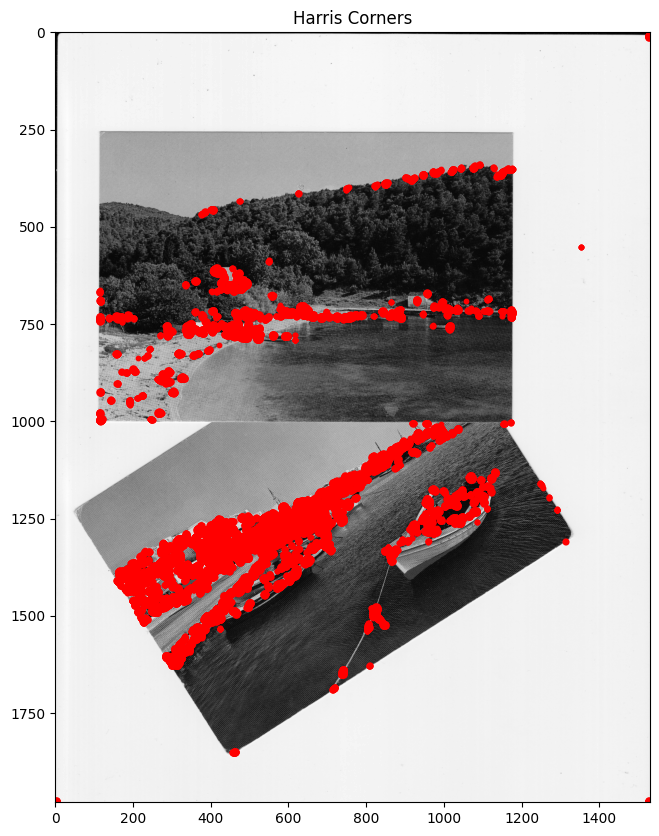

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap="gray")
plt.scatter(corners[:, 1], corners[:, 0], c="r", s=10)
plt.title("Harris Corners")
plt.show()

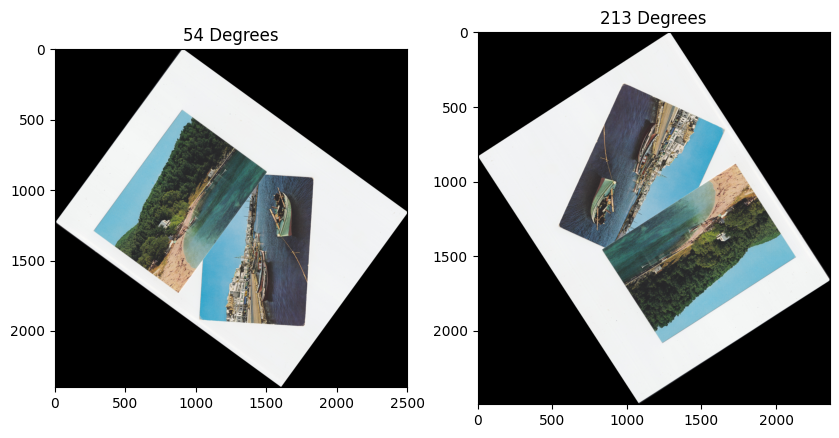

In [88]:
def my_img_rotation(img, angle):
    # Get the dimensions of the input image
    height, width = img.shape[:2]

    # Calculate the rotation matrix
    cos_theta = np.cos(angle)
    sin_theta = -np.sin(angle)

    # Calculate the new bounding box dimensions
    new_width = int(abs(height * sin_theta) + abs(width * cos_theta))
    new_height = int(abs(height * cos_theta) + abs(width * sin_theta))

    # Create the output image with black background
    if len(img.shape) == 3:
        rot_img = np.zeros((new_height, new_width, img.shape[2]), dtype=img.dtype)
    else:
        rot_img = np.zeros((new_height, new_width), dtype=img.dtype)

    # Calculate the center of the original and new image
    center_x, center_y = width // 2, height // 2
    new_center_x, new_center_y = new_width // 2, new_height // 2

    # Perform the rotation
    for i in range(new_height):
        for j in range(new_width):
            # Calculate the coordinates in the original image
            x = (
                (j - new_center_x) * cos_theta
                + (i - new_center_y) * sin_theta
                + center_x
            )
            y = (
                -(j - new_center_x) * sin_theta
                + (i - new_center_y) * cos_theta
                + center_y
            )

            if 0 <= x < width and 0 <= y < height:
                # Bilinear interpolation
                x1, y1 = int(x), int(y)
                x2, y2 = min(x1 + 1, width - 1), min(y1 + 1, height - 1)

                a = x - x1
                b = y - y1

                if len(img.shape) == 3:  # RGB image
                    for c in range(img.shape[2]):
                        rot_img[i, j, c] = (
                            (1 - a) * (1 - b) * img[y1, x1, c]
                            + a * (1 - b) * img[y1, x2, c]
                            + (1 - a) * b * img[y2, x1, c]
                            + a * b * img[y2, x2, c]
                        )
                else:  # Grayscale image
                    rot_img[i, j] = (
                        (1 - a) * (1 - b) * img[y1, x1]
                        + a * (1 - b) * img[y1, x2]
                        + (1 - a) * b * img[y2, x1]
                        + a * b * img[y2, x2]
                    )

    return rot_img


# Example usage
img = np.copy(original)
angle_54 = (np.pi / 180) * 54  # 54 degrees
angle_213 = (np.pi / 180) * 213  # 213 degrees
rotated_img_54 = my_img_rotation(img, angle_54)
rotated_img_213 = my_img_rotation(img, angle_213)
# add two subplots for the two rotated images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rotated_img_54, cmap="gray")
plt.title("54 Degrees")
plt.subplot(1, 2, 2)
plt.imshow(rotated_img_213, cmap="gray")
plt.title("213 Degrees")
plt.show()